# 1D Diffusion model for CO<sub>2</sub> absorbtion in the ocean
## Some initial help for Project 1

In this notebook, you will find a solver for tri-diagonal linear systems, that you can use to solve Eq. (28) in the project description. You will also find an example of creating a tri-diagonal sparse matrix, using this to calculated the matrix-vector product in Eq. (27) in the project description, and an example of using the solver.

# 1D Diffusion model for CO<sub>2</sub> absorbtion in the ocean
## Some initial help for Project 1

In this notebook, you will find a solver for tri-diagonal linear systems, that you can use to solve Eq. (28) in the project description. You will also find an example of creating a tri-diagonal sparse matrix, using this to calculated the matrix-vector product in Eq. (27) in the project description, and an example of using the solver.

# 1D Diffusion model for CO<sub>2</sub> absorbtion in the ocean
## Some initial help for Project 1

In this notebook, you will find a solver for tri-diagonal linear systems, that you can use to solve Eq. (28) in the project description. You will also find an example of creating a tri-diagonal sparse matrix, using this to calculated the matrix-vector product in Eq. (27) in the project description, and an example of using the solver.

## Importing libraries

In [1]:
# Matplotlib for plotting
%matplotlib inline
from matplotlib import pyplot as plt

# Numpy for almost everything
import numpy as np

# Some scipy functions for sparse diagonal matrices
from scipy.sparse import diags

# scipy function to numerically calculate integral
from scipy.integrate import simps

# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
from numba import jit

## Tri-Diagonal Matrix Algorithm (TDMA)

In [2]:
# just-in-time (jit) compiler from numba, to speed up the loop in the TDMA solver
# If this line gives you trouble, then you can either
# install numba (recommended) or you can comment it out
@jit(nopython = True)
def tdma_solver(a, b, c, d):
    # Solves Ax = d,
    # where layout of matrix A is
    # b1 c1 ......... 0
    # a2 b2 c2 ........
    # .. a3 b3 c3 .....
    # .................
    # .............. cN-1
    # 0 ..........aN bN
    # Note index offset of a
    N = len(d)
    c_ = np.zeros(N-1)
    d_ = np.zeros(N)
    x  = np.zeros(N)
    c_[0] = c[0]/b[0]
    d_[0] = d[0]/b[0]
    for i in range(1, N-1):
        c_[i] = c[i]/(b[i] - a[i-1]*c_[i-1])
    for i in range(1, N):
        d_[i] = (d[i] - a[i-1]*d_[i-1])/(b[i] - a[i-1]*c_[i-1])
    x[-1] = d_[-1]
    for i in range(N-2, -1, -1):
        x[i] = d_[i] - c_[i]*x[i+1]
    return x

def tdma(A, b):
    # Solves Ax = b to find x
    # This is a wrapper function, which unpacks
    # A from a sparse diagonal matrix structure into separate diagonals,
    # and pass them to the numba-compiled solver defined above.
    # Note, this method needs A to be diagonally dominant
    # (which it will be, for this problem)
    x = tdma_solver(A.diagonal(-1), A.diagonal(0), A.diagonal(1), b)
    return x

## Example of creating sparse matrix, and using the TDMA solver

In this project, you will have to create two tri-diagonal matrices ($\mathbf{L}$ and $\mathbf{R}$ described on pages 8 and 9 in the project description). One way of doing this is two create three one-dimensional arrays to hold the main, the upper and the lower diagonal, and then store these in a sparse array structure from scipy. We will show an example of this below.

**Note:** the matrices created here are _**not**_ the actual matrices you will need in the project, they are just somewhat similar to give you an idea of how to set up the matrices you will need.

In [3]:
# Size of system is N+1
N = 10
# Just a parameter
a = 0.35

# Creating example diagonals for L
L_main  = 1 + 2*a*np.ones(N+1)
L_upper = -a*np.ones(N)
L_lower = -a*np.ones(N)

# Creating example diagonals for R
R_main  = 1 - 2*a*np.ones(N+1)
R_upper = a*np.ones(N)
R_lower = a*np.ones(N)

# Creating sparse matrices
# Give a list of the diagonals, and a corresponding list of offsets
# offset of 0 is the main diagonal, offset -1 is the first lower diagonal, etc.
# (scipy.sparse.diags was imported above)
L = diags([L_upper, L_main, L_lower], offsets = [1, 0, -1])
R = diags([R_upper, R_main, R_lower], offsets = [1, 0, -1])

# Initial concentration, a linear function from 0 to 1 in this example
C0 = np.linspace(0, 1, N+1)

# For solving an equation such as L*C1 = R*C0, to find C1 when we know C0,
# we then first calculate the matrix-vector product R*C0, using the built-in
# method .dot() of the diagonal sparse array structure
rhs = R.dot(C0)
# Then we solve the linear equation system L*C1 = rhs to find C1
C1 = tdma(L, rhs)

Text(0.5, 1.0, '$\\mathbf{R}$')

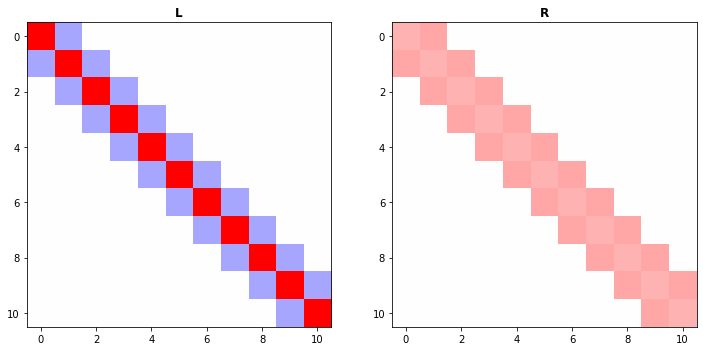

In [4]:
# Just to illustrate the concept of tri-diagonal matrices, we can plot these.
# All the white squares correspond to 0 values

fig, ax = plt.subplots(ncols = 2, figsize = (12,6))
ax[0].imshow(L.todense(), cmap = plt.cm.bwr, vmin = -1, vmax = 1)
ax[0].set_title('$\mathbf{L}$')
ax[1].imshow(R.todense(), cmap = plt.cm.bwr, vmin = -1, vmax = 1)
ax[1].set_title('$\mathbf{R}$')